<a href="https://colab.research.google.com/github/zjminglead/BESTORE/blob/master/consumer_behavior_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 基于POS数据的消费者行为分析

## 描述

+ 此处的数据集是在零售店进行的交易示例。 商店希望更好地了解客户对不同产品的购买行为。 具体来说，这里的问题是一个回归问题，我们试图借助其他变量中包含的信息来预测因变量（购买量）。

+ 分类问题也可以在这个数据集中解决，因为几个变量是分类的，其他一些方法可以是“预测消费者的年龄”甚至“预测购买的商品类别”。 这个数据集对于聚类也特别方便，可能会在其中找到不同的消费者集群。

[database link](https://www.kaggle.com/sdolezel/black-friday)

# 数据和依赖包的载入

## 常规链接到云盘

In [9]:
from google.colab import drive
drive.mount('/content/drive')
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


In [14]:
import os
ROOT = "/content/drive"
PROJ = "MyDrive/BESTROE/machine_learning/consumer_hub/consumer_behavior" # This is a custom path.
PROJECT_PATH = os.path.join(ROOT, PROJ)

os.chdir(PROJECT_PATH)
# 返回上一级目录
# os.chdir('../')
# %cd ~/content
# %cd drive/My Drive/TFConfig
print(os.getcwd())
!ls

/content/drive/MyDrive/BESTROE/machine_learning/consumer_hub/consumer_behavior
black_friday.zip  consumer_behavior_analysis.ipynb  test.csv  train.csv


## 加载python包

In [15]:
import zipfile  #解压zip包

# 数据熟悉包
import numpy as np # 线性代数包
import pandas as pd # 数据准备包
import matplotlib.pyplot as plt # 可视化包
import seaborn as sns

# 数据准备包
from sklearn.preprocessing import LabelEncoder # 编码包
from sklearn.model_selection import train_test_split # 切片数据集包
from sklearn.preprocessing import StandardScaler # 数据标准化包

# 机器学习模型创建包
from sklearn.ensemble import RandomForestRegressor ## Random Forest Regressor
from sklearn.neighbors import KNeighborsRegressor ## KNN regressor
from sklearn.tree import DecisionTreeRegressor ## Decision Tree Regressor

# 模型超参数调优包
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# 模型评估包
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae


## 绘图等全局设置

In [3]:
%matplotlib inline
sns.set_style("whitegrid")
sns.set_palette("Blues_d")
%config InlineBackend.figure_format = 'svg'

## 解压数据文件

- [zipfile参考](https://hackergu.com/how-to-unzip-by-python/)

In [16]:
# 查看zip包中的信息
file_dir = 'black_friday.zip'
zip_File = zipfile.ZipFile(file_dir,'r')
zip_list = zip_File.namelist()

#打印列表信息
print(zip_list)

#解压
zip_File.extractall()
!ls

['test.csv', 'train.csv']
black_friday.zip  consumer_behavior_analysis.ipynb  test.csv  train.csv


# 数据部分

## 1.数据熟悉部分
* 数据类型查看
* 数值类型
* 其他类型

In [19]:
# 查看数据类型
# 如果一列中含有多个类型,则该列的类型会是object,同样字符串类型的列也会被当成object类型.不同的数据类型也会被当成object,比如int32,float32
df = pd.read_csv('train.csv')
df.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

In [20]:
print('数据的大小：{}'.format(df.shape))
df.head(5)

数据的大小：(550068, 12)


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


### 数值类型

In [21]:
# 数值类型总体统计信息
df.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


### 非数值类型

In [22]:
df.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')

In [23]:
# Object类型包括哪些列
df.dtypes[df.dtypes == 'object']

Product_ID                    object
Gender                        object
Age                           object
City_Category                 object
Stay_In_Current_City_Years    object
dtype: object

In [24]:
# object类型的相关统计信息
df.describe(include="object")
# ID唯一， 男女2个， 年龄段7个区间，城市等级三种：A,B,C，在当前城市的居住时间，区间：1年内，2年内，...

,Product_ID,Gender,Age,City_Category,Stay_In_Current_City_Years
count,550068,550068,550068,550068,550068
unique,3631,2,7,3,5
top,P00265242,M,26-35,B,1
freq,1880,414259,219587,231173,193821


### 查看相关特征列

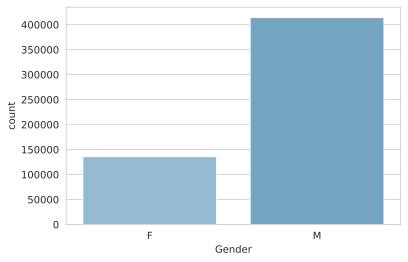

In [25]:
# 查看男女性别
sns.countplot(x='Gender', data=df)

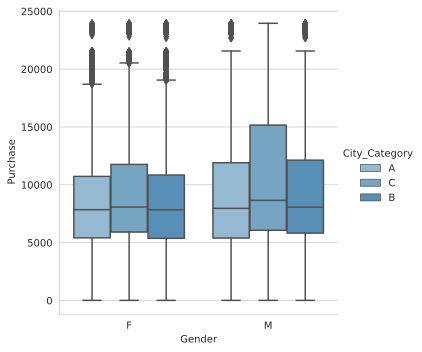

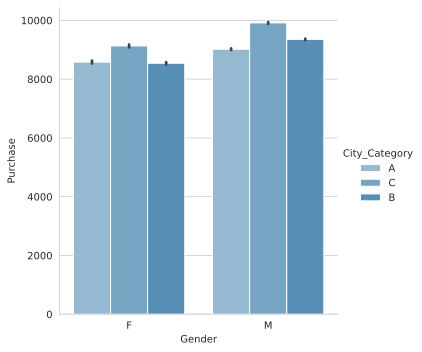

In [26]:
# 用户性别，购买力，城市等级关联分析
# C城市的用户购买力更高
sns.catplot(x="Gender", y="Purchase", hue="City_Category", kind='box', data=df)
sns.catplot(x="Gender", y="Purchase", hue="City_Category", kind='bar', data=df)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


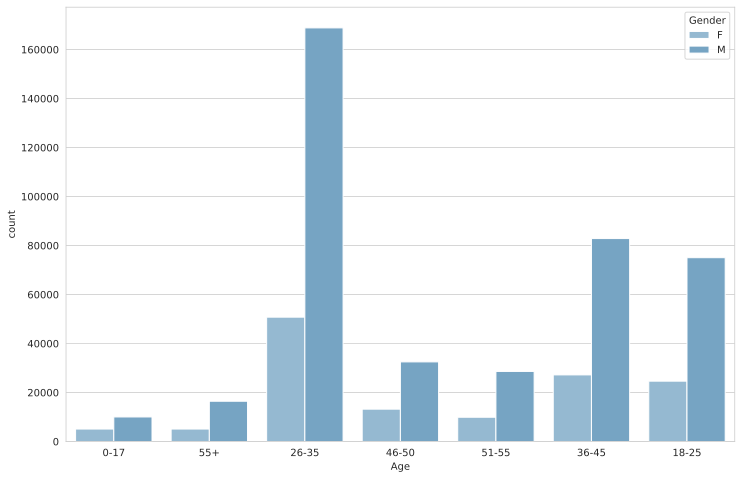

In [27]:
# 统计年龄区间分组的的男女个数
fig1, ax1 = plt.subplots(figsize=(12,8))
sns.countplot(df['Age'],hue=df['Gender'])

In [32]:
def plot(group,column,plot):
    ax=plt.figure(figsize=(12,6))
    df.groupby(group)[column].sum().sort_values().plot(kind = plot)
    

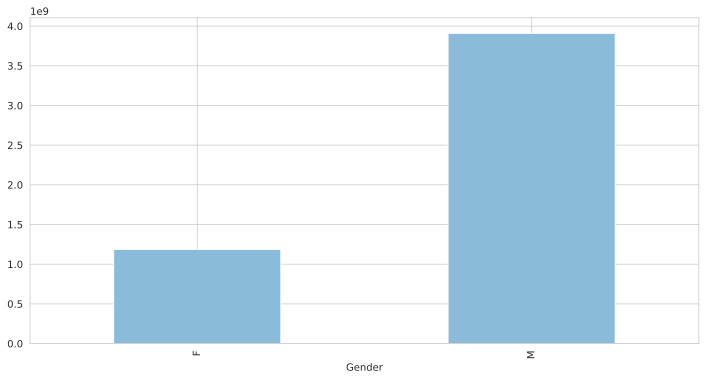

In [33]:
plot('Gender','Purchase','bar')

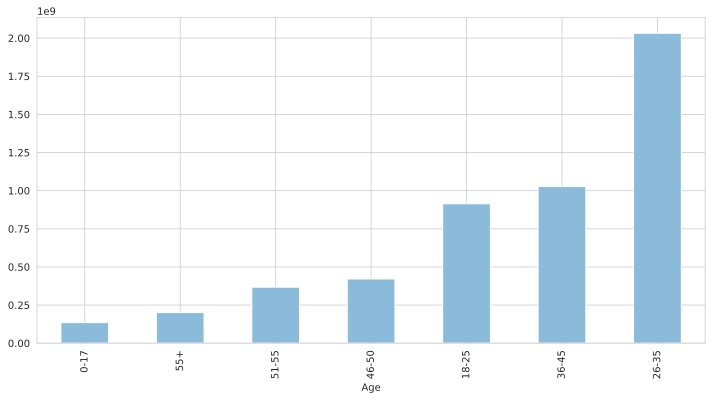

In [35]:
# 统计年龄区间分组的的男女个数
plot('Age','Purchase','bar')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


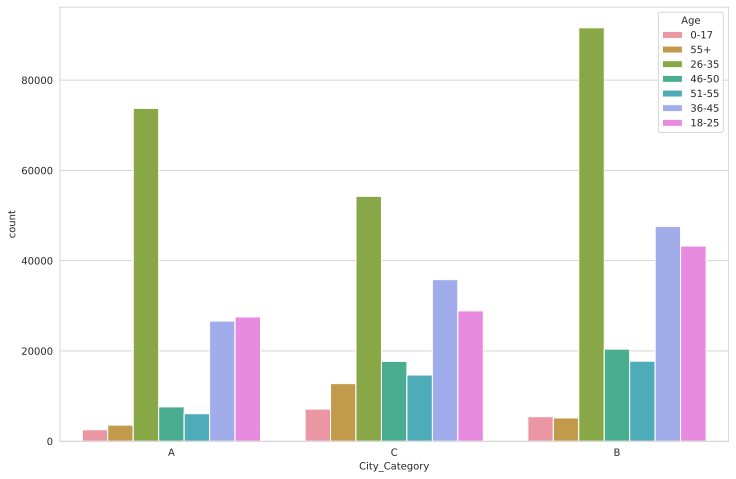

In [29]:
fig1, ax1 = plt.subplots(figsize=(12,8))
sns.countplot(df['City_Category'],hue=df['Age'])

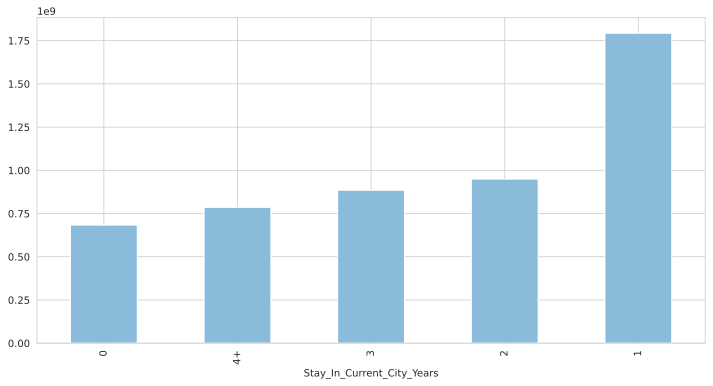

In [36]:
plot('Stay_In_Current_City_Years','Purchase','bar')

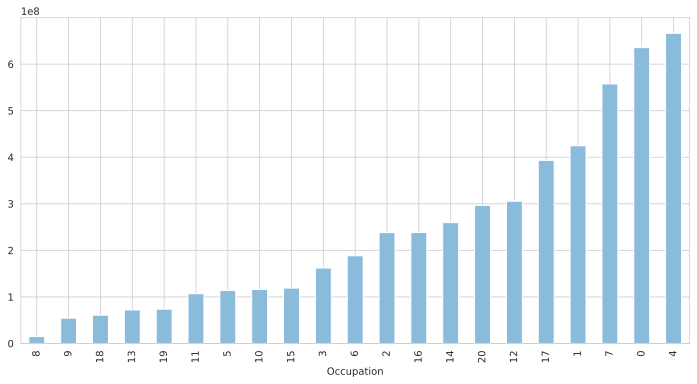

In [37]:
plot('Occupation','Purchase','bar')

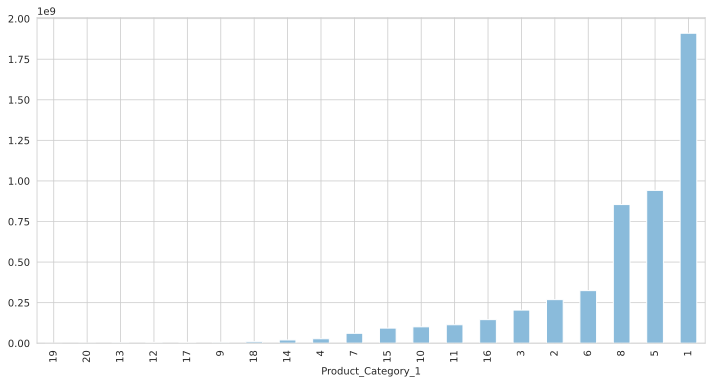

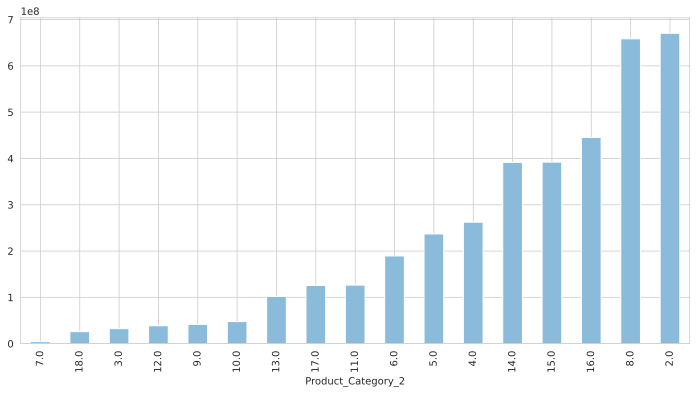

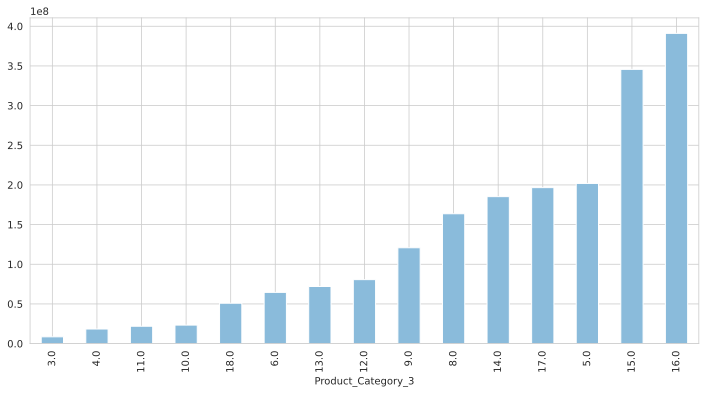

In [38]:
plot('Product_Category_1','Purchase','bar')
plot('Product_Category_2','Purchase','bar')
plot('Product_Category_3','Purchase','bar')

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


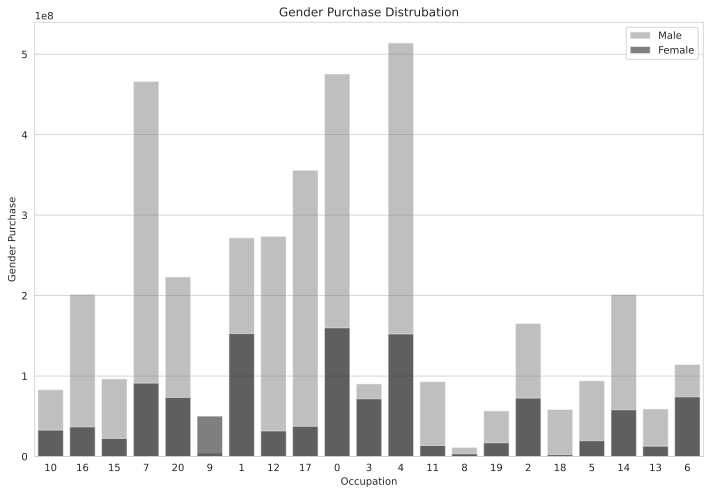

In [40]:
# 性别和职业的联合对应的购买力
df_ogp = df[['Occupation', 'Gender', 'Purchase']]
# 职业转成字符串
df_ogp.Occupation = df_ogp.Occupation.astype(str)
# 构建职业列表
occulist = list(df_ogp.Occupation.unique())
male = []
female = []
for occu in occulist:
    df_ogp_temp = df_ogp[df_ogp.Occupation == occu]
    male.append(df_ogp_temp[df_ogp_temp.Gender=='M']['Purchase'].sum())
    female.append(df_ogp_temp[df_ogp_temp.Gender=='F']['Purchase'].sum())

df_occupurgen = pd.DataFrame({'Occupation':occulist, 'male':male, 'female':female})

# 可视化

plt.subplots(figsize = (12,8))
sns.barplot(x = df_occupurgen.Occupation, y = df_occupurgen.male, 
            alpha = 0.5, label = 'Male', color = 'grey')
sns.barplot(x = df_occupurgen.Occupation, y = df_occupurgen.female,
            alpha = 0.5, label = 'Female', color= 'black')

plt.title('Gender Purchase Distrubation')
plt.xlabel('Occupation')
plt.ylabel('Gender Purchase')
plt.legend()
plt.show()

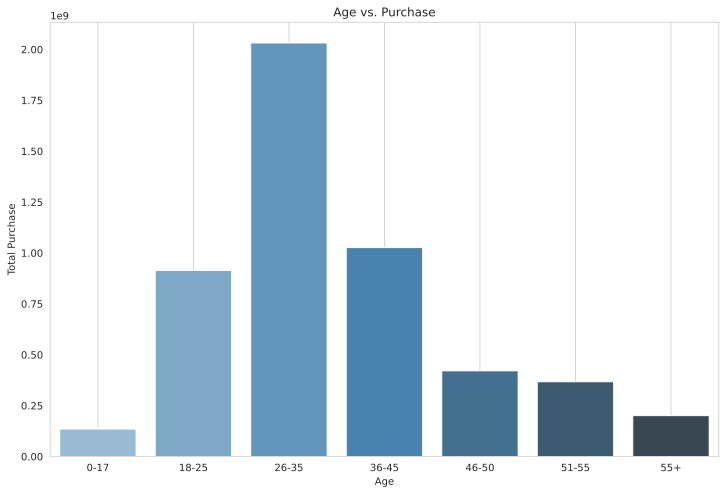

In [43]:
# 将年龄区间数值化
df.replace(['0-17','18-25','26-35','36-45','46-50','51-55','55+'],[0,1,2,3,4,5,6],inplace=True)
agelist = list(df.Age.unique())
purchasesum=[]
for age in agelist:
    purchasesum.append(df[df.Age == age].Purchase.sum())

fig, ax =plt.subplots(figsize=(12,8))
sns.barplot(x=agelist, y=purchasesum, palette="Blues_d")
ax.set_xticklabels(['0-17','18-25','26-35','36-45','46-50','51-55','55+'])
plt.title('Age vs. Purchase')
plt.xlabel('Age')
plt.ylabel('Total Purchase')
plt.grid()
plt.show()

### 数值类型协方差热值图

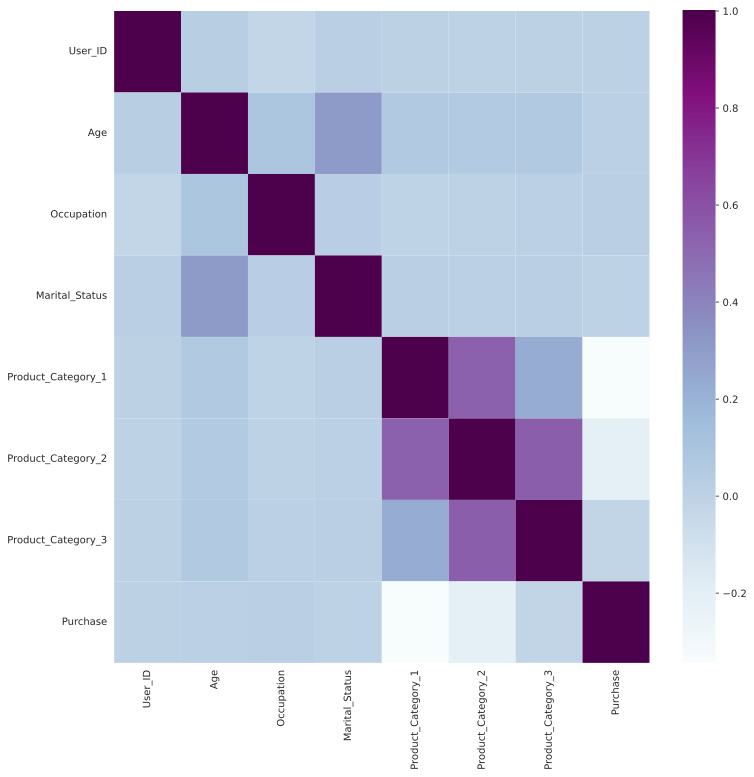

In [44]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), cmap="BuPu")

年龄和婚姻有很大关系，三种品类之间有交叉

## 2.数据清洗和准备

* 过滤数据
* 指标变量
* 编码虚拟变量

### 过滤数据

- 异常值以及NAN数据处理
- 去掉重复的行

In [47]:
# 判断缺失值个数
df.isnull().sum()
# plt.figure(figsize=(12,10))
# sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap = 'BuPu')

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

In [57]:
df.Product_Category_2.unique()

In [58]:
# 发现有nan直接用0填充
df.Product_Category_2.fillna(0, inplace=True)
df.Product_Category_2.unique()


array([ 0.,  6., 14.,  2.,  8., 15., 16., 11.,  5.,  3.,  4., 12.,  9.,
       10., 17., 13.,  7., 18.])

In [50]:
df.Product_Category_3.unique()

array([nan, 14., 17.,  5.,  4., 16., 15.,  8.,  9., 13.,  6., 12.,  3.,
       18., 11., 10.])

In [51]:
df.Product_Category_3.fillna(0, inplace=True)
df.Product_Category_3.unique()

array([ 0., 14., 17.,  5.,  4., 16., 15.,  8.,  9., 13.,  6., 12.,  3.,
       18., 11., 10.])

In [59]:
# 去掉重复的行
df = df.drop_duplicates()
print(df.shape)

(550068, 12)


In [60]:
# object的空值判断
df.select_dtypes(exclude=['object']).isnull().sum()

User_ID               0
Age                   0
Occupation            0
Marital_Status        0
Product_Category_1    0
Product_Category_2    0
Product_Category_3    0
Purchase              0
dtype: int64

### 指标变量选型

这里没有做哈

- 增加派生变量特征

### 编码虚拟特征变量

In [61]:
def gender(x):
    if x=='M':
        return 1
    else:      
        return 0

df['Gender']=df['Gender'].map(gender)

In [62]:
def agegroup(x):
    if x=='0-17':
        return 1
    elif x=='18-25':
        return 2
    elif x ==  "26-35" :
        return 3
    elif x ==  "36-45" :
        return 4
    elif x ==  "46-50" :
        return 5
    elif x ==  "51-55" :
        return 6
    elif x ==  "55+" :
        return 7
    else:
        return 0

df['AgeGroup']=df['Age'].map(agegroup) # 增加AgeGroup列

In [63]:
df.drop(['Age'],axis=1,inplace=True) # 去掉'Age'列

In [67]:
df['Bachelor']=((df.AgeGroup == 2) & (df.Marital_Status == 0) & (df.Gender == 1)).astype(int) # 过滤出18-25岁的，没有结婚的男性
df.Bachelor.unique()

array([0])

In [69]:
df.head(5)

,User_ID,Product_ID,Gender,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,AgeGroup,Bachelor
0,1000001,P00069042,0,10,A,2,0,3,0.0,0.0,8370,0,0
1,1000001,P00248942,0,10,A,2,0,1,6.0,14.0,15200,0,0
2,1000001,P00087842,0,10,A,2,0,12,0.0,0.0,1422,0,0
3,1000001,P00085442,0,10,A,2,0,12,14.0,0.0,1057,0,0
4,1000002,P00285442,1,16,C,4+,0,8,0.0,0.0,7969,0,0


In [68]:
df[df['Bachelor']==1].shape[0]/df.shape[0] 

0.0

In [70]:
df.isnull().sum()

User_ID                       0
Product_ID                    0
Gender                        0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Purchase                      0
AgeGroup                      0
Bachelor                      0
dtype: int64

### 独热编码

In [71]:
P = LabelEncoder()
df['Product_ID'] = P.fit_transform(df['Product_ID'])
U = LabelEncoder()
df['User_ID'] = P.fit_transform(df['User_ID'])


In [72]:
# get_dummies 是利用pandas实现one hot encode的方式
df = pd.get_dummies(df, columns=['City_Category', 'Stay_In_Current_City_Years'])


In [73]:
df.shape

(550068, 19)

In [74]:
df.head()

,User_ID,Product_ID,Gender,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,AgeGroup,Bachelor,City_Category_A,City_Category_B,City_Category_C,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+
0,0,672,0,10,0,3,0.0,0.0,8370,0,0,1,0,0,0,0,1,0,0
1,0,2376,0,10,0,1,6.0,14.0,15200,0,0,1,0,0,0,0,1,0,0
2,0,852,0,10,0,12,0.0,0.0,1422,0,0,1,0,0,0,0,1,0,0
3,0,828,0,10,0,12,14.0,0.0,1057,0,0,1,0,0,0,0,1,0,0
4,1,2734,1,16,0,8,0.0,0.0,7969,0,0,0,0,1,0,0,0,0,1


In [75]:
df.isnull().sum()

User_ID                          0
Product_ID                       0
Gender                           0
Occupation                       0
Marital_Status                   0
Product_Category_1               0
Product_Category_2               0
Product_Category_3               0
Purchase                         0
AgeGroup                         0
Bachelor                         0
City_Category_A                  0
City_Category_B                  0
City_Category_C                  0
Stay_In_Current_City_Years_0     0
Stay_In_Current_City_Years_1     0
Stay_In_Current_City_Years_2     0
Stay_In_Current_City_Years_3     0
Stay_In_Current_City_Years_4+    0
dtype: int64

# 模型部分

* Test Train Split
* Data Standardization

### 测试集和训练集分离

- [df.sample的用法](https://vimsky.com/zh-tw/examples/usage/python-pandas.DataFrame.sample.html)

### 采样模型数据

In [77]:
sample_df = df.sample(n=400000,random_state=100)
# df.sample(frac=0.6, random_state=1)
sample_df.head()

,User_ID,Product_ID,Gender,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,AgeGroup,Bachelor,City_Category_A,City_Category_B,City_Category_C,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+
343184,4688,2666,1,0,1,11,0.0,0.0,3051,0,0,1,0,0,0,1,0,0,0
544675,5693,3368,0,7,1,3,4.0,5.0,13692,0,0,1,0,0,0,0,0,0,1
433588,753,1087,0,3,0,5,13.0,16.0,8592,0,0,0,1,0,0,1,0,0,0
123193,1018,340,1,10,0,4,5.0,0.0,2761,0,0,0,0,1,0,1,0,0,0
161124,909,2404,1,15,1,1,15.0,16.0,15918,0,0,1,0,0,0,0,1,0,0


In [78]:
# 设置标签列
y = sample_df.Purchase
# 去掉标签列，其他作为输出
X = sample_df.drop('Purchase', axis=1)

In [79]:
# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

### 数据归一化

In [84]:
# 正太分布归一化
train_mean = X_train.mean()
train_std = X_train.std()
X_train = (X_train - train_mean) / train_std
X_train.fillna(0, inplace=True)
X_test = (X_test - train_mean) / train_std
X_test.fillna(0, inplace=True)

### 查看归一化后的数据是否有NAN

In [85]:
X_train.describe()

,User_ID,Product_ID,Gender,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,AgeGroup,Bachelor,City_Category_A,City_Category_B,City_Category_C,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+
count,3.200000e+05,3.200000e+05,3.200000e+05,3.200000e+05,3.200000e+05,3.200000e+05,3.200000e+05,3.200000e+05,320000.0,320000.0,3.200000e+05,3.200000e+05,3.200000e+05,3.200000e+05,3.200000e+05,3.200000e+05,3.200000e+05,3.200000e+05
mean,-3.667656e-17,3.547961e-17,7.597520e-16,4.937543e-16,-3.122402e-15,1.818685e-15,3.995894e-16,-1.227425e-14,0.0,0.0,1.485123e-14,2.049470e-15,2.841671e-16,2.045887e-15,1.015502e-14,-1.265810e-15,-4.833733e-15,6.373971e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.747950e+00,-1.687424e+00,-1.744697e+00,-1.239319e+00,-8.317044e-01,-1.120277e+00,-1.084090e+00,-6.143850e-01,0.0,0.0,-6.054681e-01,-8.507051e-01,-6.732477e-01,-3.945321e-01,-7.364915e-01,-4.774992e-01,-4.581810e-01,-4.274097e-01
25%,-8.784222e-01,-7.678647e-01,5.731635e-01,-9.328464e-01,-8.317044e-01,-1.120277e+00,-1.084090e+00,-6.143850e-01,0.0,0.0,-6.054681e-01,-8.507051e-01,-6.732477e-01,-3.945321e-01,-7.364915e-01,-4.774992e-01,-4.581810e-01,-4.274097e-01
50%,2.432036e-02,-4.210490e-02,5.731635e-01,-1.666662e-01,-8.317044e-01,-1.021847e-01,-2.796674e-01,-6.143850e-01,0.0,0.0,-6.054681e-01,-8.507051e-01,-6.732477e-01,-3.945321e-01,-7.364915e-01,-4.774992e-01,-4.581810e-01,-4.274097e-01
75%,8.422455e-01,8.329597e-01,5.731635e-01,9.059861e-01,1.202347e+00,6.613848e-01,1.168292e+00,6.655067e-01,0.0,0.0,1.651609e+00,1.175492e+00,1.485333e+00,-3.945321e-01,1.357785e+00,-4.774992e-01,-4.581810e-01,-4.274097e-01
max,1.745581e+00,1.901824e+00,5.731635e-01,1.825402e+00,1.202347e+00,3.715663e+00,1.811830e+00,2.265371e+00,0.0,0.0,1.651609e+00,1.175492e+00,1.485333e+00,2.534640e+00,1.357785e+00,2.094238e+00,2.182537e+00,2.339668e+00


In [86]:
X_test.describe()

,User_ID,Product_ID,Gender,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,AgeGroup,Bachelor,City_Category_A,City_Category_B,City_Category_C,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.0,80000.0,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,0.001742,0.000264,0.002159,0.000639,0.007138,0.003726,0.003507,-0.002343,0.0,0.0,0.005241,0.000880,-0.005950,0.001053,0.004804,-0.001085,-0.004770,-0.001176
std,0.998819,1.001104,0.998737,0.999930,1.001301,1.005017,1.001280,0.998724,0.0,0.0,1.002728,1.000147,0.997568,1.001130,1.001484,0.999127,0.995872,0.998879
min,-1.747950,-1.687424,-1.744697,-1.239319,-0.831704,-1.120277,-1.084090,-0.614385,0.0,0.0,-0.605468,-0.850705,-0.673248,-0.394532,-0.736491,-0.477499,-0.458181,-0.427410
25%,-0.874419,-0.768854,0.573164,-0.932846,-0.831704,-1.120277,-1.084090,-0.614385,0.0,0.0,-0.605468,-0.850705,-0.673248,-0.394532,-0.736491,-0.477499,-0.458181,-0.427410
50%,0.030252,-0.037161,0.573164,-0.166666,-0.831704,-0.102185,-0.279667,-0.614385,0.0,0.0,-0.605468,-0.850705,-0.673248,-0.394532,-0.736491,-0.477499,-0.458181,-0.427410
75%,0.837500,0.831971,0.573164,0.905986,1.202347,0.661385,1.168292,0.665507,0.0,0.0,1.651609,1.175492,1.485333,-0.394532,1.357785,-0.477499,-0.458181,-0.427410
max,1.745581,1.901824,0.573164,1.825402,1.202347,3.715663,1.811830,2.265371,0.0,0.0,1.651609,1.175492,1.485333,2.534640,1.357785,2.094238,2.182537,2.339668


### 模型搭建

### 设置评估函数
- MAE
- MSE

In [ ]:
y_train_pred = np.ones(y_train.shape[0])*y_train.mean()

In [ ]:
y_pred = np.ones(y_test.shape[0])*y_train.mean()

In [ ]:
print("Train Results for Baseline Model:")
print("*******************************")
print("R-squared: ", r2_score(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))

Train Results for Baseline Model:
*******************************
R-squared:  0.0
Mean Absolute Error:  4026.09453606625


In [ ]:
print("Results for Baseline Model:")
print("*******************************")

print("R-squared: ", r2_score(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Results for Baseline Model:
*******************************
R-squared:  -8.623386099482211e-05
Mean Absolute Error:  4050.79335828


### 随机森林模型创建

- 模型超参数配置
- 超参数最优化设置

In [ ]:
tuned_params = {'n_estimators': [100, 200, 300, 400, 500], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
model = RandomizedSearchCV(RandomForestRegressor(), tuned_params, n_iter=20, scoring = 'neg_mean_absolute_error', cv=5, n_jobs=-1)
model.fit(X_train, y_train)

### 查看最佳的训练结果

In [ ]:
model.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### 模型评估

In [ ]:
# Predict Train results
y_train_pred = model.predict(X_train)

In [ ]:
# Predict Test results
y_pred = model.predict(X_test)

In [ ]:
print("Train Results for Random Forest Regression:")
print("*******************************")
print("R-squared: ", r2_score(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))


Train Results for Random Forest Regression:
*******************************
R-squared:  0.8453824163027648
Mean Absolute Error:  1437.024028546741


In [ ]:
print("Test Results for Random Forest Regression:")
print("*******************************")
print("R-squared: ", r2_score(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Test Results for Random Forest Regression:
*******************************
R-squared:  0.6820908006433968
Mean Absolute Error:  2093.448069021826


### 输出特征的重要性排序

In [ ]:
indices = np.argsort(-model.feature_importances_)
print("The features in order of importance are:")
print(50*'-')
for feature in X.columns[indices]:
    print(feature)

The features in order of importance are:
--------------------------------------------------
Product_Category_1
Product_ID
User_ID
Occupation
Product_Category_2
AgeGroup
Product_Category_3
Marital_Status
Stay_In_Current_City_Years_1
Gender
City_Category_C
City_Category_A
Stay_In_Current_City_Years_2
City_Category_B
Stay_In_Current_City_Years_3
Stay_In_Current_City_Years_4+
Stay_In_Current_City_Years_0
Bachelor
